# Clipped Double Deep Q-Learning

In [1]:
import gym
import os
from collections import deque, namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import sleep

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda:0


### Untrained agent without Reinforcement Learning

In [2]:
env = gym.make('Acrobot-v1')
print(env.observation_space)
print(env.action_space)

Box(-28.274333953857422, 28.274333953857422, (6,), float32)
Discrete(3)


In [3]:
for i in range(5):
    state = env.reset()
    score = 0
    done = False
    while not done:
        env.render()
        sleep(0.01)
        action = env.action_space.sample()
        state_, reward, done, _ = env.step(action)
        score += reward
        state = state_
    print(f'Episode {i} | Score: {score}')
env.close()

Episode 0 | Score: -500.0
Episode 1 | Score: -500.0
Episode 2 | Score: -500.0
Episode 3 | Score: -500.0
Episode 4 | Score: -442.0


## Building the Clipped Double Deep Q Network

The Artificial Neural Network (ANN) takes states as input and outputs Q values of the actions

In [4]:
class ClippedDoubleDQN(nn.Module):
    def __init__(self, state_size, n_actions, lr, save_path, fc1_dims=64, fc2_dims=128):
        super(ClippedDoubleDQN, self).__init__()

        self.fc1 = nn.Linear(state_size[0], fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.save_path = os.path.join(save_path)
    def save_model_checkpoint(self):
        torch.save(self.state_dict(), self.save_path)
    
    def load_model_checkpoint(self):
        print('Loading from ->',self.save_path)
        self.load_state_dict(torch.load(self.save_path))
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        Qvalues_actions = self.fc3(x)
        return Qvalues_actions

A Replay Memory stores every experience tuple (s, a, r, s', d) the agent encounters

In [5]:
class ReplayMemory:
    def __init__(self, max_size, batch_size):
        self.deck = deque(maxlen=max_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "state_", "done"])
        self.batch_size = batch_size
    def save_experience(self, state, action, reward, state_, done):
        self.deck.append(self.experience(state, action, reward, state_, done))
    def sample(self):
        experiences = random.sample(self.deck, self.batch_size)
        states = torch.from_numpy(np.vstack(
                [xp.state for xp in experiences if xp is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack(
                [xp.action for xp in experiences if xp is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack(
                [xp.reward for xp in experiences if xp is not None])).float().to(device)
        states_ = torch.from_numpy(np.vstack(
                [xp.state_ for xp in experiences if xp is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack(
                [xp.done for xp in experiences if xp is not None]).astype(np.uint8)).to(device)
        
        return states, actions, rewards, states_, dones

An Agent class containing an ANN and Replay Memory plays the game

In [6]:
class Agent:
    def __init__(self, trialnum, env, gamma, lr, epsilon_dec_params, NN_params, memory_params):
        self.env = env
        self.epsilon = epsilon_dec_params[0]
        self.gamma = gamma
        self.epsilon_min = epsilon_dec_params[1]
        self.epsilon_rate = epsilon_dec_params[2]
        self.memory = ReplayMemory(*memory_params)
        self.Net1 = ClippedDoubleDQN(env.observation_space.shape, 
                             env.action_space.n, 
                             lr, 
                             f'checkpoints/ClippedDoubleDQN/{env.spec.id}_PolicyNet_trial{trialnum}.pth', 
                             *NN_params).to(device)
        self.Net2 = ClippedDoubleDQN(env.observation_space.shape, 
                             env.action_space.n, 
                             lr, 
                             f'checkpoints/ClippedDoubleDQN/{env.spec.id}_TargetNet_trial{trialnum}.pth', 
                             *NN_params).to(device)
        self.learn_counter = 0
        
    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()
        else:
            state = torch.tensor(state, dtype=torch.float).view(1, -1).to(device) # Output Size is (1, state_size)
            self.Net1.eval() # sets to evaluation mode (things like dropout gets deactivated)
            with torch.no_grad():
                Qvalues_actions = self.Net1(state) # Output Size is (1, n_actions)
            self.Net1.train() # sets to training mode (doesn't actually train!)
            action = torch.argmax(Qvalues_actions).item() # Output Size is 1
        return action
    
    def decrease_epsilon(self):
        self.epsilon = self.epsilon - self.epsilon_rate if self.epsilon > self.epsilon_min else self.epsilon_min
            
    def learn(self):
        if len(self.memory.deck) < self.memory.batch_size:
            return None
        
        self.Net1.optimizer.zero_grad()
        self.Net2.optimizer.zero_grad()
        experiences = self.memory.sample()
        states, actions, rewards, states_, dones = experiences
        # Q values of a batch of actions that the agent took in the past
        Q_cur1 = self.Net1(states).gather(1, actions).squeeze()
        Q_cur2 = self.Net2(states).gather(1, actions).squeeze()
        # Get max predicted Q values (for next states) from target model
        Q_next1 = self.Net1(states_).max(dim=1)[0].detach()
        Q_next2 = self.Net2(states_).max(dim=1)[0].detach()
        Q_next_min = torch.min(Q_next1, Q_next2)
        Q_next_min[dones.squeeze()] = 0.0
        Q_target = rewards.squeeze() + self.gamma*Q_next_min
        # Be wary of dimensions of the loss_fn input, they must match
        loss1 = self.Net1.loss_fn(Q_cur1, Q_target).to(device)
        loss2 = self.Net2.loss_fn(Q_cur2, Q_target).to(device)
        loss1.backward()
        self.Net1.optimizer.step()
        loss2.backward()
        self.Net1.optimizer.step()

        self.learn_counter += 1

## Training the Model

In [7]:
%%time
env = gym.make('Acrobot-v1')
trialnum = 2
# Hyperparameters
hps = {
    'gamma':0.99,
    'lr':0.001,
    'epsilon_init':1,
    'epsilon_min':1e-2,
    'epsilon_rate':5e-5,
    'fc1_dims':256,
    'fc2_dims':512,
    'max_size':10000,
    'batch_size':64
}
agent = Agent(
    trialnum = trialnum,
    env=env,
    gamma=hps['gamma'], 
    lr=hps['lr'],
    epsilon_dec_params = (hps['epsilon_init'], hps['epsilon_min'], hps['epsilon_rate']),
    NN_params=(hps['fc1_dims'], hps['fc2_dims']), 
    memory_params=(hps['max_size'], hps['batch_size'])
)
best_score = -np.inf
best_reached_at = -1
scores, avg_scores = [], []
N = 1000
for i in range(N):
    state = env.reset()
    score = 0
    done = False
    t = 0
    while not done:
        action = agent.choose_action(state)
        state_, reward, done, _ = env.step(action)
#         if (i+1) % 50 == 0:
#             env.render()
#             sleep(0.01)
        score += reward
        agent.memory.save_experience(state, action, reward, state_, done)
        agent.learn()
        agent.decrease_epsilon()
        state = state_
        t += 1
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)
    if avg_score > best_score:
        best_score = avg_score
        best_reached_at = i+1
        agent.Net1.save_model_checkpoint()
        agent.Net2.save_model_checkpoint()
        
#     if avg_score >= 200:
#         print(f"Env solved in {i+1} episodes -> {avg_score}")
#         break
    if (i+1) % 10 == 0:
        print(f'Episode {i+1} Score: {round(score, 2)} Avg Score: {avg_score:.2f}',
              f'Best Score: {best_score:.2f} Eps: {round(agent.epsilon, 3)}')
env.close()

/home/aryamaansaha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755861072/work/aten/src/ATen/native/cuda/Indexing.cu:967.)


Episode 10 Score: -500.0 Avg Score: -500.00 Best Score: -500.00 Eps: 0.75
Episode 20 Score: -252.0 Avg Score: -404.25 Best Score: -404.25 Eps: 0.595
Episode 30 Score: -217.0 Avg Score: -336.37 Best Score: -336.37 Eps: 0.494
Episode 40 Score: -219.0 Avg Score: -296.43 Best Score: -296.43 Eps: 0.406
Episode 50 Score: -166.0 Avg Score: -269.00 Best Score: -269.00 Eps: 0.326
Episode 60 Score: -122.0 Avg Score: -247.52 Best Score: -247.52 Eps: 0.255
Episode 70 Score: -111.0 Avg Score: -231.26 Best Score: -231.26 Eps: 0.188
Episode 80 Score: -114.0 Avg Score: -220.03 Best Score: -220.03 Eps: 0.116
Episode 90 Score: -88.0 Avg Score: -207.08 Best Score: -207.08 Eps: 0.064
Episode 100 Score: -86.0 Avg Score: -197.59 Best Score: -197.59 Eps: 0.01
Episode 110 Score: -77.0 Avg Score: -157.95 Best Score: -157.95 Eps: 0.01
Episode 120 Score: -98.0 Avg Score: -137.28 Best Score: -137.28 Eps: 0.01
Episode 130 Score: -83.0 Avg Score: -127.38 Best Score: -127.38 Eps: 0.01
Episode 140 Score: -79.0 Avg Sc

### Storing the results and hyperparameters

In [8]:
agent_dict = {'Algorithm':'ClippedDoubleDQN', 'Trial':trialnum, 'Best Score':best_score, 
              'Best at':best_reached_at, 'Trained till':len(scores), 'hyperparams':hps}
os.chdir(os.path.join(os.getcwd(), 'History'))
with open(f'{env.spec.id}_history.txt', 'a+') as file:
    file.write(f'{agent_dict}\n\n')
os.chdir('../')

## Plotting Scores

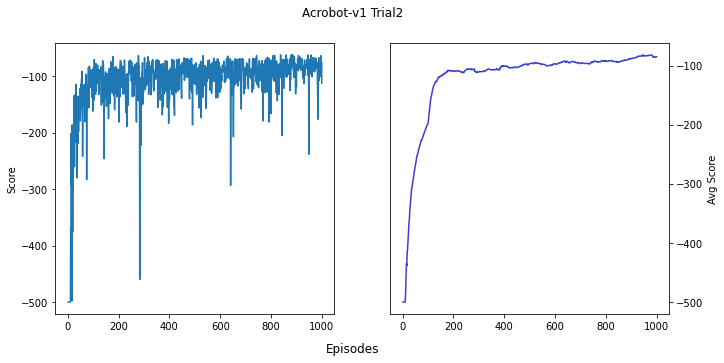

In [9]:
def plot_graph(x, avg_scores, scores, figpath):
    fig = plt.figure(figsize=(11, 5))
    fig.suptitle(f'{env.spec.id} Trial{trialnum}')
    fig.supxlabel("Episodes")
    
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax.plot(x, scores, color='#1f77b4')
    ax.set_ylabel("Score")

    ax2.plot(x, avg_scores, color='#3a3fcf')
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Avg Score')
    ax2.yaxis.set_label_position('right')
    
    plt.savefig(figpath, facecolor='white', transparent=False)


episode_indices = np.arange(1, len(scores)+1) 
figpath = f'graphs/ClippedDoubleDQN/{env.spec.id}_trial{trialnum}.png'

plot_graph(episode_indices, avg_scores, scores, figpath)

## Testing the Model

Epsilon is set to 0 while testing, so the agent always chooses the best action

In [12]:
env = gym.make('Acrobot-v1')
trialnum = 2
# Hyperparameters
hps = {
    'gamma':0.99,
    'lr':0.001,
    'epsilon_init':0,
    'epsilon_min':1e-2,
    'epsilon_rate':5e-5,
    'fc1_dims':256,
    'fc2_dims':512,
    'max_size':10000,
    'batch_size':64
}
print("Note: For testing, make sure Epsilon is ignored \n")
agent = Agent(
    trialnum = trialnum,
    env=env,
    gamma=hps['gamma'], 
    lr=hps['lr'],
    epsilon_dec_params = (hps['epsilon_init'], hps['epsilon_min'], hps['epsilon_rate']),
    NN_params=(hps['fc1_dims'], hps['fc2_dims']), 
    memory_params=(hps['max_size'], hps['batch_size'])
)

agent.Net1.load_model_checkpoint()
agent.Net2.load_model_checkpoint()

for i in range(5):
    done = False
    score = 0
    state = env.reset()
    while not done:
        env.render()
        sleep(0.01)
        action = agent.choose_action(state)
        state_, reward, done, _ = env.step(action)
        score += reward
        state = state_
    print('\n',score,'\n')
env.close()

Note: For testing, make sure Epsilon is ignored 

Loading from -> checkpoints/ClippedDoubleDQN/Acrobot-v1_PolicyNet_trial2.pth
Loading from -> checkpoints/ClippedDoubleDQN/Acrobot-v1_TargetNet_trial2.pth

 -87.0 


 -70.0 


 -62.0 


 -81.0 


 -83.0 

